In [1]:
from contextlib import suppress
from zipfile import ZipFile, BadZipFile
import os

#set up Colab if detected
with suppress(ModuleNotFoundError):
    from google.colab import drive
    %pip install neptune > /dev/null
    try: #assumes repo zipped (zip -r spectrofy.zip Spectrofy -x \*.git* \*ipynb* \*.mp3 \*.pth) and uploaded
        if not os.path.exists('/content/Spectrofy'):
            with ZipFile('/content/spectrofy.zip') as zip:
                zip.extractall('/content')
        os.chdir('/content/Spectrofy')
    except (FileNotFoundError, BadZipFile): #as fallback assumes repo uploaded to Drive (training will be slower)
        drive.mount('/content/drive')
        os.chdir('/content/drive/MyDrive/Spectrofy')

In [2]:
import neptune
from getpass import getpass

#set up Neptune
log = True #enables/disables logging
if log:
    run = neptune.init_run( #the warning about interactive sessions can be ignored
        api_token = getpass('Enter your Neptune API token: '), #or paste it into the code
        project = input('Enter your Neptune project name: '))

<ipython-input-2-ba0c64246bee>:7: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run( #the warning about interactive sessions can be ignored


https://app.neptune.ai/team-n/spectrofy/e/SPEC-60


In [3]:
from utils.dataset import SpectrogramsDataset
from utils.preprocessing import transform
from torch.utils.data import random_split
from torch import Generator

#split dataset deterministically
spec_dir = os.path.join('data', 'spec')
features_path = os.path.join('data', 'features.csv')
dataset = SpectrogramsDataset(spec_dir, features_path, transform, target='danceability')
trainset, valset, testset = random_split(dataset, [0.8, 0.1, 0.1], Generator().manual_seed(42))
len(trainset), len(valset), len(testset)

(4373, 546, 546)

In [4]:
from torch.utils.data import DataLoader

#configure batches
loader_args = {
    'batch_size': 128, #large so smooth
    'num_workers': 2,
    'pin_memory': True,
    'drop_last': True}
train_loader = DataLoader(trainset, shuffle=True, persistent_workers=True, **loader_args)
val_loader = DataLoader(valset, persistent_workers=True, **loader_args)
test_loader = DataLoader(testset, **loader_args)
batch_size, channels, height, width = next(iter(train_loader))[0].shape

#log dataset
if log:
    run['dataset'] = {
        'target': dataset.target,
        'train-validation-test': (
            f'{len(trainset)}-' #whole because reshuffled at each epoch
            f'{batch_size * len(val_loader)}-'
            f'{batch_size * len(test_loader)}'),
        'batch_size': batch_size,
        'channels-height-width': f'{channels}-{height}-{width}'}
channels, height, width

(3, 224, 224)

In [5]:
import torch
import importlib; from utils import models; importlib.reload(models) #for debugging purposes
from utils.models import DanceabilityModel
from torch import nn, optim
import inspect

#configure training
model_args = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DanceabilityModel(**model_args).to(device)
criterion = type('MSELoss', (nn.MSELoss,), {'__str__': lambda self : 'MSE'})()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#log model
if log:
    run['model'] = {
        'architecture': inspect.getsource(DanceabilityModel),
        'arguments': model_args}
device

device(type='cuda')

In [6]:
from copy import deepcopy
import numpy as np

train_losses = []
val_losses = []
best_params = None
for epoch in range(999):

    #train
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device)) #estimates loss of batch with current parameters
        optimizer.zero_grad() #resets gradient to avoid accumulation
        loss.backward() #computes gradient of loss w.r.t. parameters
        optimizer.step() #updates parameters to reduce loss
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))
    print(f'[epoch {epoch:03}] train loss: {train_losses[-1]:.4f}, ', end='')

    #evaluate on validation set
    model.eval()
    running_loss = 0
    with torch.inference_mode(): #to save memory and computations
        for inputs, labels in val_loader:
            outputs = model(inputs.to(device))
            running_loss += criterion(outputs, labels.to(device)).item()
    val_losses.append(running_loss/len(val_loader))

    #back up best parameters
    end = '\n'
    if val_losses[-1] <= min(val_losses):
        best_params = deepcopy(model.state_dict())
        end = ' (new best)\n'
    print(f'val loss: {val_losses[-1]:.4f}', end=end)

    #stop early
    patience = 5
    with suppress(IndexError):
        if all(np.array(val_losses[-patience:]) > val_losses[-patience-1]):
            break

[epoch 000] train loss: 0.0304, val loss: 0.0193 (new best)
[epoch 001] train loss: 0.0194, val loss: 0.0180 (new best)
[epoch 002] train loss: 0.0147, val loss: 0.0147 (new best)
[epoch 003] train loss: 0.0151, val loss: 0.0145 (new best)
[epoch 004] train loss: 0.0136, val loss: 0.0154
[epoch 005] train loss: 0.0136, val loss: 0.0148
[epoch 006] train loss: 0.0127, val loss: 0.0134 (new best)
[epoch 007] train loss: 0.0126, val loss: 0.0141
[epoch 008] train loss: 0.0115, val loss: 0.0131 (new best)
[epoch 009] train loss: 0.0119, val loss: 0.0126 (new best)
[epoch 010] train loss: 0.0119, val loss: 0.0141
[epoch 011] train loss: 0.0110, val loss: 0.0133
[epoch 012] train loss: 0.0116, val loss: 0.0124 (new best)
[epoch 013] train loss: 0.0107, val loss: 0.0123 (new best)
[epoch 014] train loss: 0.0110, val loss: 0.0121 (new best)
[epoch 015] train loss: 0.0112, val loss: 0.0124
[epoch 016] train loss: 0.0116, val loss: 0.0141
[epoch 017] train loss: 0.0103, val loss: 0.0119 (new bes

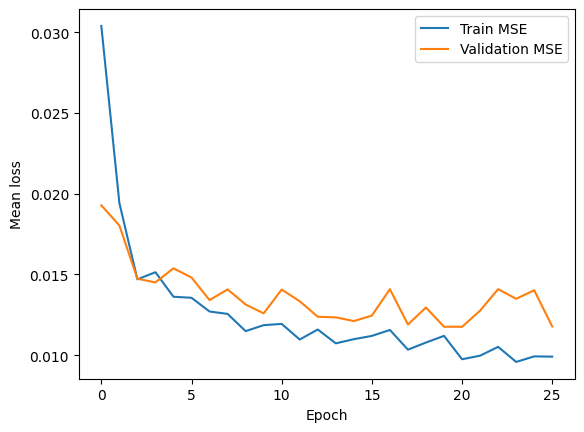

In [7]:
import matplotlib.pyplot as plt

#plot training history
plt.plot(train_losses, label=f'Train {criterion}')
plt.plot(val_losses, label=f'Validation {criterion}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
figure = plt.gcf() #will be logged

In [8]:
import torch.nn.functional as F

#evaluate on test set
model.load_state_dict(best_params)
assert not model.training
running_loss = 0
with torch.inference_mode():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        running_loss += F.l1_loss(outputs, labels.to(device)).item() #MAE for interpretability
test_mae = round(running_loss/len(test_loader), ndigits=4)
print(f'Mean absolute error on test set: {test_mae}')

#log training
if log:
    run['training'] = {
        'optimizer': str(optimizer),
        f'validation_{criterion}'.lower(): round(min(val_losses), ndigits=4),
        'test_mae': test_mae}
    run['training/history'].upload(figure)

Mean absolute error on test set: 0.0815


In [9]:
#save best parameters
param_dir = os.path.join('utils', 'model_params')
os.makedirs(param_dir, exist_ok=True)
param_path = os.path.join(param_dir, 'danceability.pth')
torch.save(best_params, param_path)

In [10]:
#test model
model = DanceabilityModel(**model_args)
model.load_state_dict(torch.load(param_path, map_location='cpu'))
model.eval()
spec, true = testset[0]
pred = model(spec).item()
print(f'[danceability] true: {true:.2f}, predicted: {pred:.2f}')

[danceability] true: 0.63, predicted: 0.67


In [11]:
#stop logging
if log:
    run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/team-n/spectrofy/e/SPEC-60/metadata
